# **Near Field Scan Measurement and Analysis Script**

For 3rd floor system with 1 meter Newmark stage. Compares single- or dual-polarization near field scan of test antenna to that of standard gain horn antenna to obtain directivity, gain, and efficiency estimates.

### Import modules

In [1]:
import sys
sys.path.append(r'C:\Users\User\Documents\Duke\Acquisition-Code\Modules')
import numpy as np
from matplotlib import pyplot as plt
# import VNA_control as vc
# import stage_control as sc
import probe_deconvolve as pd
import propagation_functions as pf
import scipy.constants
import scipy.io
import time
import datetime
# import mainPyDAC2_module as tune

C     = scipy.constants.c
EPS_0 = scipy.constants.epsilon_0 #C^2/(N*m^2)
MU_0  = scipy.constants.mu_0    #m kg s^-2 A^-2
mm = 0.001
cm    = 0.01
GHz   = 1.0E9

### General scan parameters

In [2]:
a_probe = 22.86
b_probe = 10.16

xrange = 1000 # x length of stage, mm
yrange = 1000 # y length of stage, mm

fstart = 8E9
fstop = 12E9
NumFreqs = 11
NumApMasks = 10
f = np.linspace(fstart, fstop, NumFreqs)
lam_min = C/fstop
dstep = lam_min/2 * 1000 # mm

IFBW = 1000
calfile = 'Aaron_21-11-05'
power = 0 # dBm
sParMeas = 'S12'
speedmms = 25       # don't change this

print('IFBW = {} \nCalibration File = {} \nPower = {} dBm \nMeasuring {}'.format(IFBW, calfile, power, sParMeas))

IFBW = 1000 
Calibration File = Aaron_21-11-05 
Power = 0 dBm 
Measuring S12


### Initialize instruments

In [ ]:
## Stage
g = sc.stage_start('169.254.225.173')
sc.stage_home(g,speedmms)

## Arduino
# BAUDRATE, PORTNAME, #DACS
numDACs = 12
tune.setSerial(115200, "COM7", numDACs)
tune.sendInputLen()
msg = tune.receiveFromArduino()

while msg.find("Received: " + str(numDACs) + " from serial.") == -1:
    msg = tune.receiveFromArduino()
    
if not (msg == "NO VAL"):
    print(msg)


## VNA
vna = vc.instrument_open('TCPIP0::169.254.187.153::5025::SOCKET')
vc.VNA_initiate(vna, NumFreqs, fstart*1E-9, fstop*1E-9, IFBW, power, 'S12', calfile=calfile)

## **Test antenna**

In [ ]:
mat = scipy.io.loadmat('C:/Users/smithlab/Documents/NFS_codes/Mike_Antenna_Tuning/wrc_tuning_states.mat')
ts = mat['ts'].reshape((96, 50))

savename = 'Mike_Antenna'
savepath = 'C:/Users/smithlab/Documents/Near_Field_Scans/'

### Scan

#### *Set scan lengths*

In [ ]:
Lx_ap = 130
Ly_ap = 120
theta = 30
d = 85

Lx_scan = Lx_ap + 2*d*np.tan(np.radians(theta))
Ly_scan = Ly_ap + 2*d*np.tan(np.radians(theta))

xmin = -Lx_scan/2
xmax = Lx_scan/2
ymin = -Ly_scan/2
ymax = Ly_scan/2

x_probe = np.arange(xmin, xmax, dstep)
y_probe = np.arange(ymin, ymax, dstep)
X_probe, Y_probe = np.meshgrid(x_probe, y_probe, indexing='xy')
measurements_x = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs, NumApMasks), dtype=np.complex128) # measurements with E field of probe oriented in x direction
measurements_y = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs, NumApMasks), dtype=np.complex128) # measurements with E field of probe oriented in y direction
stops = Y_probe.shape[0] * X_probe.shape[1]

#### *Move to new origin*

In [ ]:
center_x = -xrange/2
center_y = -yrange/2
pos_x = -120  # adjust to change x zero position
pos_y = 0  # adjust to change y zero position

sc.move_to_absolute(g,speedmms,0,0,center_x+pos_x,center_y+pos_y)

#### *Set origin*

In [ ]:
defZeroInXsteps, defZeroInYsteps = sc.zero_axes(g)

#### *Start scan - x-polarization*

In [ ]:
sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,X_probe[0,0],Y_probe[0,0]) # move to start position

In [ ]:
t = time.time()
stopscomp = 0

x_list = []
y_list = []
for yn in range(Y_probe.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(X_probe.shape[1])
    else:
        xindex = np.flip(np.arange(X_probe.shape[1]))
        
    for xn in xindex:
        x = X_probe[yn, xn]
        y = Y_probe[yn, xn]
        sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x,y)
        
        for jj in range(NumApMasks):
            tune.testProgram12DAC(ts[:,jj])
            time.sleep(0.01)
            measurements_x[yn,xn,:,jj] = vc.VNA_read(vna,sParMeas)
        
        stopscomp += 1
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()


#### *Start scan - y-polarization*

In [ ]:
sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,X_probe[0,0],Y_probe[0,0]) # move to start position

In [ ]:
t = time.time()
stopscomp = 0

x_list = []
y_list = []
for yn in range(Y_probe.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(X_probe.shape[1])
    else:
        xindex = np.flip(np.arange(X_probe.shape[1]))
        
    for xn in xindex:
        x = X_probe[yn, xn]
        y = Y_probe[yn, xn]
        sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x,y)
        
        for jj in range(NumApMasks):
            tune.testProgram12DAC(ts[:,jj])
            time.sleep(0.01)
            measurements_y[yn,xn,:,jj] = vc.VNA_read(vna,sParMeas)
        
        stopscomp += 1
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()


#### *Concatenate measurements*

In [ ]:
measurements = np.stack((measurements_x, measurements_y), axis=4)

### Probe compensation

In [ ]:
measurements_corrected = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs, NumApMasks, 2), dtype=np.complex128)

for i in range(NumFreqs):

    A_mat = pd.make_A_mat(f[i], a_probe*mm, b_probe*mm, x_probe*mm, y_probe*mm, d*mm)

    for j in range(NumApMasks):

        measurements_corrected[:,:,i,j,:] = np.transpose(pd.probe_deconvolve(np.transpose(measurements[:,:,i,j,:], (1,0,2)), A_mat, x_probe*mm, y_probe*mm), (1,0,2))
        
measurements_corrected = measurements    # TEMP, UNTIL PROBE CORRECTION IS SOLVED
    

### Propagate

In [ ]:
N_theta = 180
N_phi = 180

E_far = np.zeros((N_theta, N_phi, NumFreqs, NumApMasks, 3), dtype=np.complex128)

for i in range(NumFreqs):
    for j in range(NumApMasks):

        Theta_far, Phi_far, E_far[:,:,i,j,:] = pf.propagate_from_scans(measurements_corrected[:,:,i,j,:], f[i], X_probe*mm, Y_probe*mm, N_theta, N_phi, fft=False)

E_int = np.abs(np.sum(E_far * np.conjugate(E_far), 4)).astype(np.float32)

### Plot

In [ ]:
f_indx = np.argmin(np.abs(f - 10E9))
m_indx = 0

fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.imshow(np.abs(measurements[:,:,0,0,0]), extent=(np.min(x_probe), np.max(x_probe), np.min(y_probe), np.max(y_probe)))
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y (mm)')
plt.show()

fig, ax2 = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(5,5))
cs = ax2.contourf(Phi_far, Theta_far, 10*np.log10(E_int[:,:,f_indx,m_indx]/np.amax(E_int[:,:,f_indx,m_indx])), 
            np.linspace(-15, 0, 50), 
            cmap=plt.cm.hot_r)
ax2.grid(True)
ax2.set_rlabel_position(135)
fig.colorbar(cs, ticks=np.linspace(-15, 0, 7))
plt.xlabel('$\phi$')
plt.show()


### Save data

In [ ]:
scipy.io.savemat('{}{}_{}.mat'.format(savepath, savename, datetime.datetime.now().strftime('%Y-%m-%d')),
                                      {'X': X_probe,
                                       'Y': Y_probe,
                                       'Lx_ap': Lx_ap,
                                       'Ly_ap': Ly_ap,
                                       'f': f,
                                       'ts': ts,
                                       'measurements': measurements,
                                       'measurements_corrected': measurements_corrected,
                                       'Theta_far': Theta_far,
                                       'Phi_far': Phi_far,
                                       'E_far': E_far})

## **Standard gain antenna (SGA)**

In [ ]:
savename = 'SGA_X_Band_Horn'
savepath = 'C:/Users/smithlab/Documents/Near_Field_Scans/'

### Scan

#### *Set scan lengths*

In [ ]:
Lx_ap = 30
Ly_ap = 40
theta = 30
d = 85

Lx_scan = Lx_ap + 2*d*np.tan(np.radians(theta))
Ly_scan = Ly_ap + 2*d*np.tan(np.radians(theta))

xmin = -Lx_scan/2
xmax = Lx_scan/2
ymin = -Ly_scan/2
ymax = Ly_scan/2

x_probe = np.arange(xmin, xmax, dstep)
y_probe = np.arange(ymin, ymax, dstep)
X_probe, Y_probe = np.meshgrid(x_probe, y_probe, indexing='xy')
measurements_x = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs), dtype=np.complex128) # measurements with E field of probe oriented in x direction
measurements_y = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs), dtype=np.complex128) # measurements with E field of probe oriented in y direction
stops = Y_probe.shape[0] * X_probe.shape[1]

#### *Move to new origin*

In [ ]:
center_x = -xrange/2
center_y = -yrange/2
pos_x = 105  # adjust to change x zero position
pos_y = 0  # adjust to change y zero position

sc.move_to_absolute(g,speedmms,0,0,center_x+pos_x,center_y+pos_y)

#### *Set origin*

In [ ]:
defZeroInXsteps, defZeroInYsteps = sc.zero_axes(g)

#### *Start scan - x-polarization*

In [ ]:
sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,X_probe[0,0],Y_probe[0,0]) # move to start position

In [ ]:
t = time.time()
stopscomp = 0

x_list = []
y_list = []
for yn in range(Y_probe.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(X_probe.shape[1])
    else:
        xindex = np.flip(np.arange(X_probe.shape[1]))
        
    for xn in xindex:
        x = X_probe[yn, xn]
        y = Y_probe[yn, xn]
        sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x,y)

        measurements_x[yn,xn,:] = vc.VNA_read(vna,sParMeas)
        
        stopscomp += 1
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()


#### *Start scan - y-polarization*

In [ ]:
sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,X_probe[0,0],Y_probe[0,0]) # move to start position

In [ ]:
t = time.time()
stopscomp = 0

x_list = []
y_list = []
for yn in range(Y_probe.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(X_probe.shape[1])
    else:
        xindex = np.flip(np.arange(X_probe.shape[1]))
        
    for xn in xindex:
        x = X_probe[yn, xn]
        y = Y_probe[yn, xn]
        sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x,y)
        
        measurements_y[yn,xn,:] = vc.VNA_read(vna,sParMeas)
        
        stopscomp += 1
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()


#### *Concatenate measurements*

In [ ]:
measurements = np.stack((measurements_x, measurements_y), axis=3)

### Probe compensation

In [ ]:
measurements_corrected = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs, 2), dtype=np.complex128)

for i in range(NumFreqs):

    A_mat = pd.make_A_mat(f[i], a_probe*mm, b_probe*mm, x_probe*mm, y_probe*mm, d*mm)

    measurements_corrected[:,:,i,:] = np.transpose(pd.probe_deconvolve(np.transpose(measurements[:,:,i,:], (1,0,2)), A_mat, x_probe*mm, y_probe*mm), (1,0,2))
    
measurements_corrected = measurements    # TEMP, UNTIL PROBE CORRECTION IS SOLVED


### Propagate

In [ ]:
N_theta = 180
N_phi = 180

E_far = np.zeros((N_theta, N_phi, NumFreqs, 3), dtype=np.complex128)

for i in range(NumFreqs):

    Theta_far, Phi_far, E_far[:,:,i,:] = pf.propagate_from_scans(measurements_corrected[:,:,i,:], f[i], X_probe*mm, Y_probe*mm, N_theta, N_phi, fft=False)

E_int = np.abs(np.sum(E_far * np.conjugate(E_far), 3)).astype(np.float32)

### Plot

In [ ]:
f_indx = np.argmin(np.abs(f - 10E9))

fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.imshow(np.abs(measurements[:,:,0,0]), extent=(np.min(x_probe), np.max(x_probe), np.min(y_probe), np.max(y_probe)))
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y (mm)')
plt.show()

fig, ax2 = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(5,5))
cs = ax2.contourf(Phi_far, Theta_far, 10*np.log10(E_int[:,:,f_indx]/np.amax(E_int[:,:,f_indx])), 
            np.linspace(-15, 0, 50), 
            cmap=plt.cm.hot_r)
ax2.grid(True)
ax2.set_rlabel_position(135)
fig.colorbar(cs, ticks=np.linspace(-15, 0, 7))
plt.xlabel('$\phi$')
plt.show()


### Save data

In [ ]:
scipy.io.savemat('{}{}_{}.mat'.format(savepath, savename, datetime.datetime.now().strftime('%Y-%m-%d')),
                                      {'X': X_probe,
                                       'Y': Y_probe,
                                       'Lx_ap': Lx_ap,
                                       'Ly_ap': Ly_ap,
                                       'f': f,
                                       'ts': ts,
                                       'measurements': measurements,
                                       'measurements_corrected': measurements_corrected,
                                       'Theta_far': Theta_far,
                                       'Phi_far': Phi_far,
                                       'E_far': E_far})

## **Calculate beam metrics**

### Load data if not already available

In [3]:
AUT = scipy.io.loadmat(r'C:\Users\User\Documents\Duke\Projects\DARPA\Data\Mike_Antenna\Near Field Scans\Mike_Antenna_2022-02-17')
SGA = scipy.io.loadmat(r'C:\Users\User\Documents\Duke\Projects\DARPA\Data\Mike_Antenna\Near Field Scans\SGA_X_Band_Horn_2022-02-17')

### Calculate gain, directivity, beamwidth, and efficiency

In [39]:
Theta_far_AUT = AUT['Theta_far']
Theta_far_SGA = SGA['Theta_far']
Phi_far_AUT = AUT['Phi_far']
Phi_far_SGA = SGA['Phi_far']
E_AUT = AUT['E_far']
E_SGA = SGA['E_far']
f = AUT['f']
f_indx = np.argmin(np.abs(f - 10E9))

Lx_ap = 130
Ly_ap = 120

U_int_AUT = np.abs(np.sum(E_AUT * np.conjugate(E_AUT), 4)).astype(np.float32)
U_int_SGA = np.abs(np.sum(E_SGA * np.conjugate(E_SGA), 3)).astype(np.float32)
U_peak_AUT = np.amax(U_int_AUT, axis=(0,1))
U_peak_SGA = np.amax(U_int_SGA, axis=(0,1))

P_rad_AUT = np.trapz(np.trapz(U_int_AUT * np.sin(Theta_far_AUT[:,:,None,None]), np.unique(Theta_far_AUT), axis=0), np.unique(Phi_far_AUT), axis=0)

C = 3E8
lam = C/f[0,:]

D_max = 4*np.pi*np.amax(U_int_AUT, axis=(0,1))/P_rad_AUT
f_indx = np.argmin(np.abs(f - 10E9))
print('Directivity =', 10*np.log10(D_max[f_indx,0]), 'dBi')
D_theoretical = 4*np.pi*(Lx_ap/1000 * Ly_ap/1000)/lam[f_indx]**2
print(10*np.log10(D_theoretical))

gain_AUT = 10 + 10*np.log10(U_peak_AUT/U_peak_SGA[:,None])
print('Gain:', gain_AUT[f_indx,0])

e = 10**(gain_AUT/10) / D_max
print('Efficiency:', e[f_indx,0])

(11, 10)
Directivity = 20.764465961274425 dBi
23.38091952937233
Gain: 7.5747747
Efficiency: 0.04797675479646209


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


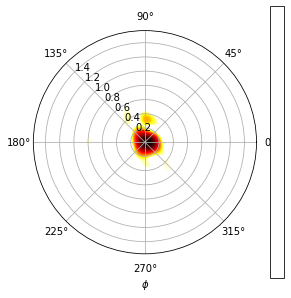

In [30]:
f_indx = np.argmin(np.abs(f - 10E9))
m_indx = 3
E_int = np.sum(E_AUT * np.conjugate(E_AUT), axis=4)

# fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
# ax1.imshow(measurements[:,:,0,0,0], extent=(np.min(x_probe), np.max(x_probe), np.min(y_probe), np.max(y_probe)))
# ax1.set_xlabel('x (mm)')
# ax1.set_ylabel('y (mm)')
# plt.show()

fig, ax2 = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(5,5))
cs = ax2.contourf(Phi_far_AUT, Theta_far_AUT, 10*np.log10(E_int[:,:,f_indx,m_indx]/np.amax(E_int[:,:,f_indx,m_indx])), 
            np.linspace(-15, 0, 50), 
            cmap=plt.cm.hot_r)
ax2.grid(True)
ax2.set_rlabel_position(135)
fig.colorbar(cs, ticks=np.linspace(-15, 0, 7))
plt.xlabel('$\phi$')
plt.show()
